In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab12.ipynb")

# Lab 12: Principal Component Analysis

In this lab assignment, we will walk through two examples that use Principal Component Analysis (PCA): one involving a dataset of [iris plants](https://en.wikipedia.org/wiki/Iris_plant), and another involving an artificial "surfboard" 3D dataset.


### Due Date

This assignment is due **Tuesday, November 15th at 11:59 pm PST**.

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** The recording was from Spring 2022, where this lab was labeled Lab 11.

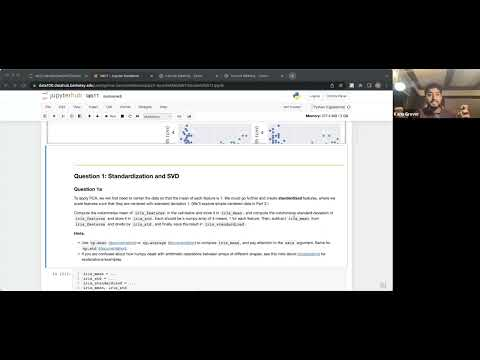

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("gXZ9BJN6zB8", list = 'PLQCcNQgUcDfqC3hTWqqEErLjHaPq0Yk3A', listType = 'playlist')

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

In [3]:
# Run this cell to set up your notebook
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
%matplotlib inline

<br/>

In lecture we discussed how Principal Component Analysis (PCA) can be used for dimensionality reduction. Specifically, given a high dimensional dataset, PCA allows us to:
1. Understand the rank of the data. If $k$ principal components capture almost all of the variance, then the data is roughly rank $k$.
2. Create 2D scatterplots of the data. Such plots are a rank 2 representation of our data, and allow us to visually identify clusters of similar observations.

In this lab, you'll learn how to perform PCA using the `np.linalg` package (Part 1), and you'll also build a geometric intuition of PCA to help you understand its strengths (Part 2). We work with low-dimensional datasets for now to focus on the basics; in the homework, you'll explore how PCA works on a high-dimensional dataset.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 1: The Iris Dataset

To begin, run the following cell to load the dataset into this notebook. 
* `iris_features` will contain a numpy array of 4 attributes for 150 different plants (shape `150 x 4`). 
* `iris_target` will contain the class of each plant. There are 3 classes of plants in the dataset: Iris-Setosa, Iris-Versicolour, and Iris-Virginica. The class names will be stored in `iris_target_names`.
* `iris_feature_names` will be a list of 4 names, one for each attribute in `iris_features`. 

In [4]:
# just run this cell

from sklearn.datasets import load_iris
iris_data = load_iris() # Loading the dataset

# Unpacking the data into arrays
iris_features = iris_data['data']
iris_target = iris_data['target']
iris_feature_names = iris_data['feature_names']
iris_target_names = iris_data['target_names']

# Convert iris_target to string labels instead of int labels currently (0, 1, 2) for the classes
iris_target = iris_target_names[iris_target]

Let's explore the data by creating a scatter matrix of our iris features. To do this, we'll create 2D scatter plots for every possible pair of our four features. This should result in six total scatter plots in our scatter matrix with the classes labeled in distinct colors for each plot.

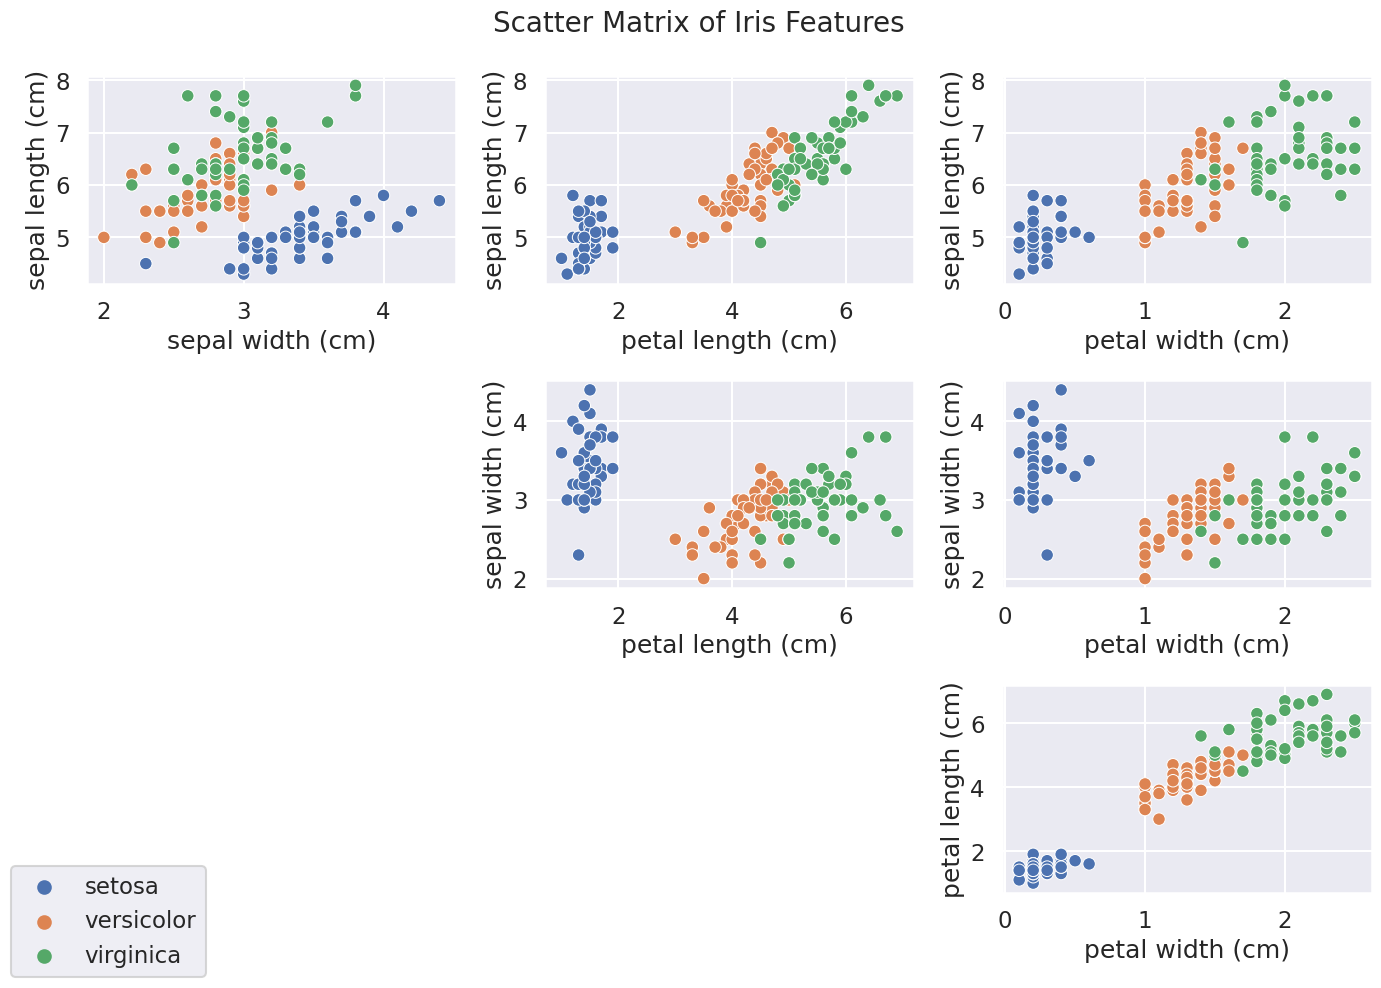

In [5]:
# just run this cell
fig = plt.figure(figsize=(14, 10))
plt.suptitle("Scatter Matrix of Iris Features", fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i in range(1, 4):
    for j in range(i):
        plot_index = 3*j + i
        plt.subplot(3, 3, plot_index)
        sns.scatterplot(x=iris_features[:, i],
                        y=iris_features[:, j],
                        hue=iris_target,
                       legend=(plot_index == 1))
        plt.xlabel(iris_feature_names[i])
        plt.ylabel(iris_feature_names[j])
        if plot_index == 1:
            plt.legend().remove()

fig.legend(loc='lower left') # same legend for all subplots
fig.tight_layout()
plt.show()

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 1: Standardization and SVD

### Question 1a

To apply PCA, we will first need to center the data so that the mean of each feature is 0. We will also go further and create **standardized** features, where we scale features such that they are centered with standard deviation 1. (We'll explore simple centered data in Part 2.)

Compute the columnwise mean of `iris_features` in the cell below and store it in `iris_mean`, and compute the columnwise standard deviation of `iris_features` and store it in `iris_std`. Each should be a numpy array of 4 means/standard deviations, 1 for each feature. Then, subtract `iris_mean` from `iris_features` and divide by `iris_std`, and finally, save the result in `iris_standardized`.

**Hints:** 
* Use `np.mean` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)) or `np.average` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.average.html)) to compute `iris_mean`, and pay attention to the `axis` argument. Same for `np.std` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.std.html)).
* If you are confused about how numpy deals with arithmetic operations between arrays of different shapes, see this note about [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) for explanations/examples.

In [13]:
iris_mean = np.mean(iris_features, axis=0)
iris_std = np.std(iris_features, axis=0)
iris_standardized = (iris_features - iris_mean) / iris_std
iris_mean, iris_std

(array([5.84333333, 3.05733333, 3.758     , 1.19933333]),
 array([0.82530129, 0.43441097, 1.75940407, 0.75969263]))

In [14]:
grader.check("q1a")

q1a results: All test cases passed!

<br/><br/>

---

### Question 1b

As you may recall from lecture, PCA is a specific application of the singular value decomposition (SVD) for matrices. In the following cell, let's use the `np.linalg.svd` function ([documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)) to compute the SVD of our `iris_standardized` matrix. 

Store the left singular vectors $U$, singular values $\Sigma$, and (transposed) right singular vectors $V^T$ in `u`, `s`, and `vt`, respectively. Set the `full_matrices` argument of `np.linalg.svd` to `False`.

In [25]:
u, s, vt = np.linalg.svd(iris_standardized, full_matrices=False)
u.shape, s, vt.shape

((150, 4), array([20.92306556, 11.7091661 ,  4.69185798,  1.76273239]), (4, 4))

In [26]:
grader.check("q1b")

q1b results: All test cases passed!

<br/><br/>

---

### Question 1c

What can we learn from the singular values in `s`?

As discussed in lecture, the total variance of the data is also equal to the sum of the squares of the singular values divided by the number of data points, that is:

$$\text{Var}(X) = \frac{\sum_{i=1}^d{\sigma_i^2}}{N} = \sum_{i=1}^d \frac{\sigma_i^2}{N}$$

where for data $X$ with $N$ datapoints and $d$ features, $\sigma_i$ is the singular value corresponding to the $i$-th principal component, and $\text{Var}(X)$ is the total variance of the data. The right-hand side implies that the expression $\sigma_i^2/N$ is the amount of variance captured by the $i$-th principal component.

Compute the total variance of our data below by summing the square of each singular value in `s` and dividing the result by the total number of data points. Store the result in the variable `iris_total_variance`.

In [27]:
iris_total_variance = np.sum(s**2) / iris_standardized.shape[0]

print("iris_total_variance: {:.3f} should approximately equal the sum of the feature variances: {:.3f}"
      .format(iris_total_variance, np.sum(np.var(iris_standardized, axis=0))))

iris_total_variance: 4.000 should approximately equal the sum of the feature variances: 4.000


In [28]:
grader.check("q1c")

q1c results: All test cases passed!

As you can see, `iris_total_variance` is equal to the sum of the standardized feature variances. Since our features are standardized (i.e., have mean 0 and variance 1), `iris_total_variance` is equal to the number of original features.

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 2

### Question 2a

Let's now use only the first two principal components to see what a 2D version of our iris data looks like.

First, construct the 2D version of the iris data by multiplying our `iris_standardized` array with the first two right singular vectors in $V$. Because the first two right singular vectors are directions for the first two principal components, this will project the iris data down from a 4D subspace to a 2D subspace.

**Hints:**
* To matrix-multiply two numpy arrays, use `@` or `np.dot`. In case you're interested, the [matmul documentation](https://numpy.org/devdocs/reference/generated/numpy.matmul.html) contrasts the two methods.
* Note that in Question 1b, you computed `vt` (SVD decomposition is $U\Sigma V^T$). The first two right singular vectors in $V$ will be the two rows of `vt`, [transposed](https://numpy.org/devdocs/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T) to be column vectors instead of row vectors. 
* Since we want to obtain a 2D version of our iris dataset, the shape of `iris_2d` should be (150, 2).

In [30]:
iris_2d = iris_standardized @ vt[0:2, :].T
np.sum(iris_2d[:, 0])

-2.4158453015843406e-13

In [31]:
grader.check("q2a")

q2a results: All test cases passed!

<br/><br/>

Now, run the cell below to create the scatter plot of our 2D version of the iris data, `iris_2d`.

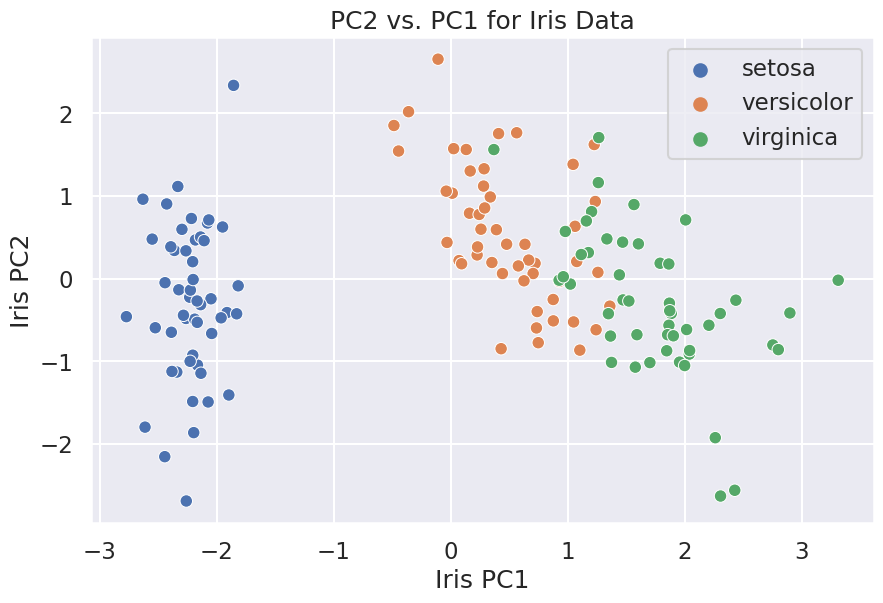

In [32]:
# just run this cell
plt.figure(figsize = (9, 6))
plt.title("PC2 vs. PC1 for Iris Data")
plt.xlabel("Iris PC1")
plt.ylabel("Iris PC2")
sns.scatterplot(x = iris_2d[:, 0], y = iris_2d[:, 1], hue = iris_target);

<br/><br/>

---

### Question 2b

What do you observe about the plot above? If you were given a point in the subspace defined by PC1 and PC2, how well would you be able to classify the point as one of the three Iris types?

There are clear deliniations with the graph shown above. More particularyl, versicolor and virginica are harder to differentiate than setosa. The are closely clustered together, but they also have higher PC1 scores.

<br/><br/>

---
### Question 2c

What proportion of the total variance is accounted for when we project the iris data down to two dimensions? Compute this quantity in the cell below by dividing the variance captured by the first two singular values (also known as component scores) in `s` by the `iris_total_variance` you calculated previously. Store the result in `iris_2d_variance`.

In [33]:
iris_2d_variance = np.sum(s[:2]**2) / iris_standardized.shape[0] / iris_total_variance
iris_2d_variance

0.9581320720000164

In [34]:
grader.check("q2c")

q2c results: All test cases passed!

Most of the variance in the data is explained by the two-dimensional projection!

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 3

As a last step, we will create a [scree plot](https://en.wikipedia.org/wiki/Scree_plot) to visualize the weight of each principal component. In the cell below, create a scree plot by creating a line plot of the component scores (variance captured by each principal component) vs. the principal component number (1st, 2nd, 3rd, or 4th). Your graph should match the image below:

*Hint:* Be sure to label your axes appropriately! You may find `plt.xticks()` ([documentation](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.xticks.html)) helpful for formatting.

<img src="images/scree.png" width="400px" />

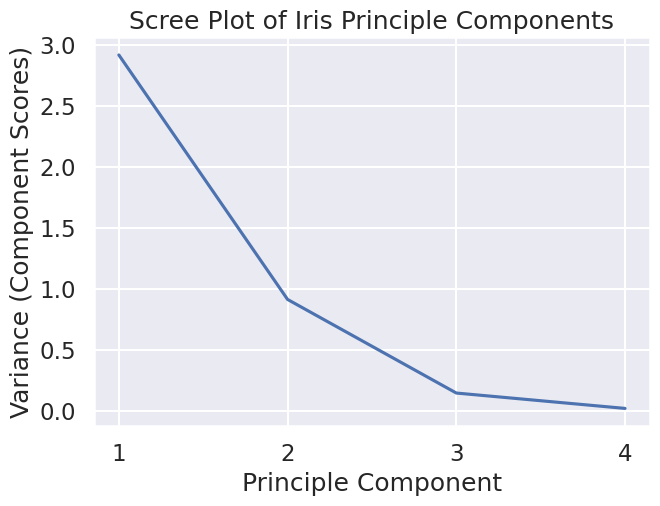

In [40]:
# your plot here
plt.xticks([1, 2, 3, 4])
plt.xlabel("Principle Component")
plt.ylabel("Variance (Component Scores)")
plt.title("Scree Plot of Iris Principle Components")
plt.plot([1, 2, 3, 4], np.square(s)/iris_standardized.shape[0])

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 2: PCA on 3D Data

**In Part 2, our goal is to see visually how PCA is simply the process of rotating the coordinate axes of our data.**

The code below reads in a 3D dataset. We have named the DataFrame `surfboard` because the data resembles a surfboard when plotted in 3D space.

In [41]:
# just run this cell
surfboard = pd.read_csv("data/data3d.csv")
surfboard.head(5)

x         y         z
0  0.005605  2.298191  1.746604
1 -1.093255  2.457522  0.170309
2  0.060946  0.473669 -0.003543
3 -1.761945  2.151108  3.132426
4  1.950637 -0.194469 -2.101949

### [Tutorial 1] Visualize the Data

The cell below will allow you to view the data as a 3D scatterplot. Rotate the data around and zoom in and out using your trackpad or the controls at the top right of the figure.

You should see that the data is an ellipsoid that looks roughly like a surfboard or a [hashbrown patty](https://www.google.com/search?q=hashbrown+patty&source=lnms&tbm=isch). That is, it is pretty long in one direction, pretty wide in another direction, and relatively thin along its third dimension. We can think of these as the "length", "width", and "thickness" of the surfboard data.

Observe that the surfboard is not aligned with the x/y/z axes.

If you get an error that your browser does not support webgl, you may need to restart your kernel and/or browser.

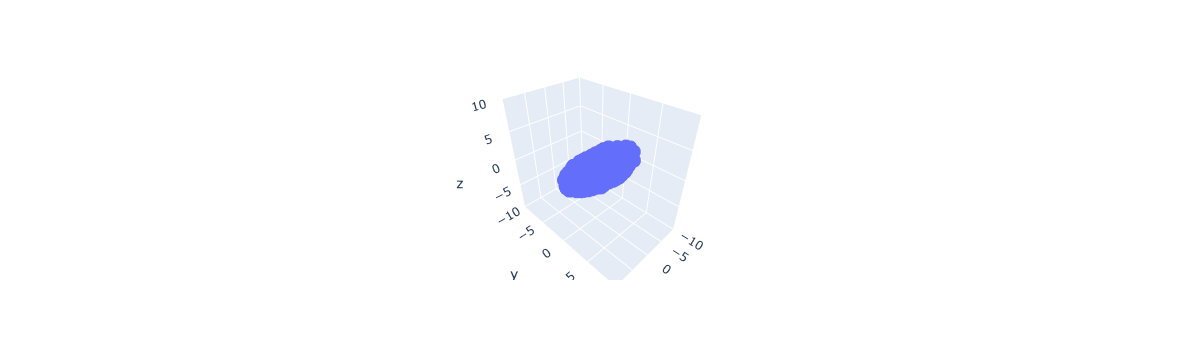

In [42]:
# just run this cell
fig = px.scatter_3d(surfboard, 
                    x='x', y='y', z='z', 
                    range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10])
fig.show()

**Visualize the Data (Colorized)**

To give the figure a little more visual pop, the following cell does the same plot, but also assigns a pre-determined color value (that we've arbitrarily chosen) to each point. *These colors do not mean anything important*; they're simply there as a visual aid.

You might find it useful to use the `colorize_surfboard_data` method later in this lab.

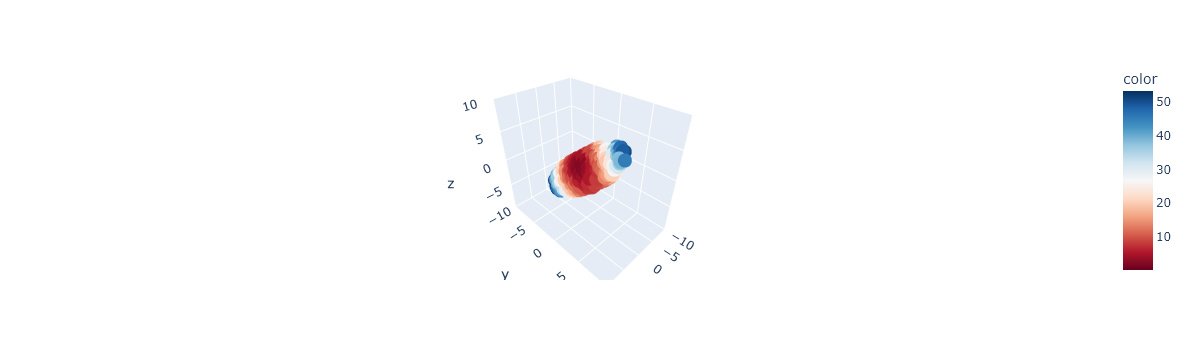

In [43]:
# just run this cell (the colorized version of previous cell)
def colorize_surfboard_data(df):
    colors = pd.read_csv("data/surfboard_colors.csv", header = None).values
    df_copy = df.copy()
    df_copy.insert(loc = 3, column = "color", value = colors)
    return df_copy
    
fig = px.scatter_3d(colorize_surfboard_data(surfboard), 
                    x='x', y='y', z='z', 
                    range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10], 
                    color = "color", color_continuous_scale = 'RdBu')
fig.show()

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 4: Centering and SVD

### Question 4a

In Part 1, we standardized the Iris data prior to performing SVD, i.e., we made features zero-mean and unit-variance. In this part, we'll try just **centering** our data so that each feature is zero-mean and variance is unchanged.

Compute the columnwise mean of `surfboard` in the cell below, and store the result in `surfboard_mean`. You can choose to make `surfboard_mean` a numpy array or a series, whichever is more convenient for you. Regardless of what data type you use, `surfboard_mean` should have 3 means: 1 for each attribute, with the x coordinate first, then y, then z.

Then, subtract `surfboard_mean` from `surfboard`, and save the result in `surfboard_centered`. The order of the columns in `surfboard_centered` should be x, then y, then z.

In [44]:
surfboard_mean = np.mean(surfboard, axis=0)
surfboard_centered = surfboard - surfboard_mean

In [45]:
grader.check("q4a")

q4a results: All test cases passed!

<br/><br/>

---

### Question 4b

In the following cell, compute the singular value decomposition (SVD) of `surfboard_centered` as $U\Sigma V^T$, and store the left singular vectors $U$, singular values $\Sigma$, and (transposed) right singular vectors $V^T$ in `u2`, `s2`, and `vt2`, respectively.

Your code should be very similar to Part 1, Question 1b up above.

In [46]:
u2, s2, vt2 = np.linalg.svd(surfboard_centered, full_matrices=False)
u2, s2, vt2

(array([[-0.02551985,  0.02108339,  0.03408865],
        [-0.02103979,  0.0259219 , -0.05432967],
        [-0.00283413,  0.00809889, -0.00204459],
        ...,
        [ 0.01536972,  0.00483066, -0.05673824],
        [-0.00917593, -0.0345672 , -0.03491181],
        [-0.01701236, -0.02743128,  0.01966704]]),
 array([103.76854043,  40.38357469,  21.04757518]),
 array([[ 0.38544534, -0.67267377, -0.63161847],
        [ 0.5457216 ,  0.7181477 , -0.43180066],
        [ 0.74405633, -0.17825229,  0.64389929]]))

In [47]:
grader.check("q4b")

q4b results: All test cases passed!

<br/><br/>

---

### Question 4c: Total Variance

In Part 1 Question 1c, we considered standardized features (each with unit variance), whose total variance was simply the count of features. Now, we'll show that the same relationship holds between singular values `s` and the variance of our (unstandardized) data.

In the cell below, compute the total variance as the sum of the squares of the singular values $\sigma_i$ divided by the number of datapoints $N$. Here's that formula again from Question 1c:

$$\text{Var}(X) = \frac{\sum_{i=1}^d{\sigma_i^2}}{N} = \sum_{i=1}^d \frac{\sigma_i^2}{N}$$

In [48]:
total_variance_computed_from_singular_values = np.sum(s2**2) / surfboard_centered.shape[0]
total_variance_computed_from_singular_values

12.841743509780105

In [49]:
grader.check("q4c")

q4c results: All test cases passed!

<br/>

Your `total_variance_computed_from_singular_values` result should be very close to the total variance of the original `surfboard` data:

In [50]:
# run this cell
np.var(surfboard, axis=0)

x    2.330704
y    5.727527
z    4.783513
dtype: float64

The total variance of our dataset is given by the sum of these numbers.

In [51]:
# run this cell
total_variance_computed_from_surfboard = sum(np.var(surfboard, axis=0))
total_variance_computed_from_surfboard

12.841743509780109



Note: The variances are the same for both `surfboard_centered` and `surfboard` (why?), so we show only one to avoid redundancy.

<br/><br/>

---

### Question 4d: Variance Explained by First Principal Component

In the cell below, set `variance_explained_by_1st_pc` to the proportion of the total variance explained by the 1st principal component. Your answer should be a number between 0 and 1.

In [52]:
variance_explained_by_1st_pc = np.sum(s2[:1]**2) / surfboard_centered.shape[0] / total_variance_computed_from_surfboard
variance_explained_by_1st_pc

0.8385084140449129

In [53]:
grader.check("q4d")

q4d results: All test cases passed!

<br/>

We can also create a scree plot that shows the proportion of variance explained by all of our principal components, ordered from most to least. You already constructed a scree plot for the Iris data, so we'll leave the surfboard scree plot for you to do on your own time.

Instaed, let's try to visualize why PCA is simply a rotation of the coordinate axes (i.e., features) of our data.

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 5: V as a Rotation Matrix

In lecture, we saw that the first column of $XV$ contained the first principal component values for each observation, the second column of $XV$ contained the second principal component values for each observation, and so forth.

Let's give this matrix a name: $P = XV$ is sometimes known as the "principal component matrix".

Compute the $P$ matrix for the surfboard dataset and store it in the variable `surfboard_pcs`.

Hint: What does $X$ represent here: `surfboard` or `surfboard_centered`? Why?

In [55]:
surfboard_pcs = surfboard_centered @ vt2.T

In [56]:
grader.check("q5")

q5 results: All test cases passed!

---

### [Tutorial 2] Visualizing the Principal Component Matrix

In some sense, we can think of $P$ as an output of the PCA procedure.

$P$ is a **rotation** of the data such that the data will now appear "axis aligned". Specifically, for a 3d dataset, if we plot PC1, PC2, and PC3 along the x, y, and z axes of our plot, then the greatest amount of variation happens along the x-axis, the second greatest amount along the y-axis, and the smallest amount along the z-axis. 

To visualize this, run the cell below, which will show our data now projected onto the principal component space. Compare with your original figure (from Tutorial 1 in this part), and observe that the data is exactly the same—only it is now rotated.

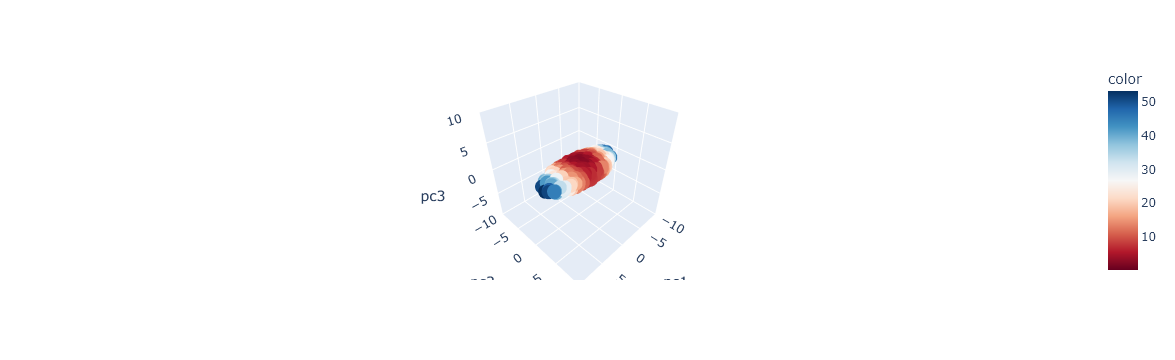

In [57]:
# just run this cell
surfboard_pcs = surfboard_pcs.rename(columns = {0: "pc1", 1: "pc2", 2: "pc3"})
fig = px.scatter_3d(colorize_surfboard_data(surfboard_pcs), 
                    x='pc1', y='pc2', z='pc3', 
                    range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10], 
                    color = 'color', color_continuous_scale = 'RdBu');
fig.show();

We can also create a 2D scatterplot of our surfboard data as well. Note that the resulting is just the 3D plot as viewed from directly "overhead".

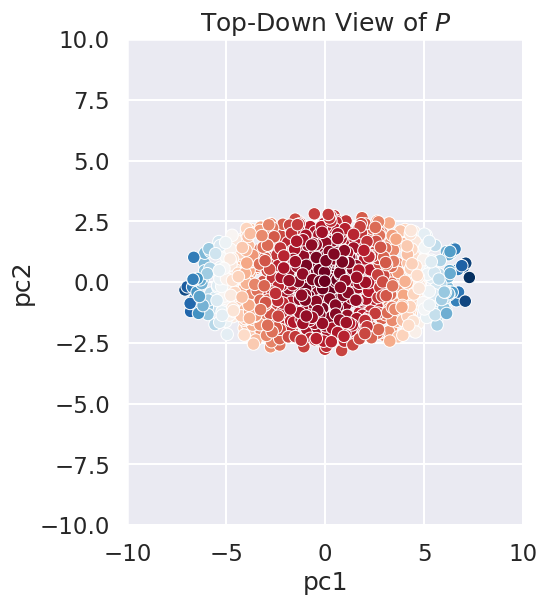

In [58]:
# just run this cell
fig = plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
# just run this cell
sns.scatterplot(data = colorize_surfboard_data(surfboard_pcs), 
                x = 'pc1', y = 'pc2', hue = "color", palette = "RdBu", legend = False)
plt.xlim(-10, 10);
plt.ylim(-10, 10);
plt.title("Top-Down View of $P$")
plt.show()

### Part 2 Summary

Above, we saw that the principal component matrix $P$ is simply the original data rotated in space so that it appears axis-aligned.

Whenever we do a 2D scatter plot of only the first 2 columns of $P$, we are simply looking at the data from "above", i.e. so that the 3rd (or higher) PC is invisible to us.

# Congratulations! You finished the lab!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)